In [1]:
import matplotlib as mpl
import os, sys
mpl.use('Agg')
from LiteNet import *
import tensorflow as tf
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from time import time
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

In [2]:
from nystrom_kexpfam.data_generators.Gaussian import GaussianGridWrapped
from nystrom_kexpfam.data_generators.Ring import Ring
#from nystrom_kexpfam.data_generators.Dataset import GlassPosteriorDataset

from nystrom_kexpfam.log import logger
from nystrom_kexpfam.visualisation import visualise_array_2d

from nystrom_kexpfam.estimators.KMCLite import KMCLite

INFO: 2018-05-02 23:42:17,324: log.<module>(): Global logger initialised with loglevel 20
INFO: 2018-05-02 23:42:17,632: log.<module>(): Global logger initialised with loglevel 20
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 68, in init_dev
    context.cudnn_handl

In [110]:
D = 2
p = Ring(D=D, sigma=0.1
         , N_train=10000, N_test=10000)
def gen_data(n):
    
    # random uniform
    # rand_data1 = np.c_[np.random.uniform(-6,2,n/2), np.random.uniform(-7,-2,n/2)]
    # rand_data2 = np.c_[np.random.uniform(2,7,n/2) , np.random.uniform(-2,6,n/2)]
    # rand_data  = np.r_[rand_data1, rand_data2]

    # gaussian mixture
    #rand_data1  = np.random.randn(n/2,2)*3-3
    #rand_data2  = np.random.randn(n/2,2)*3+3
    #rand_data  = np.r_[rand_data1, rand_data2]
    
    # full cov gaussian
    #rand_data  = np.random.randn(n,D)*np.sqrt(2)
    
    # fixed grid
    # rand_data = np.array([[xv,yv] for xv in np.linspace(-6,2,50) for yv in np.linspace(-7,-2,50)])
    # rand_data = np.array([[xv,yv] for xv in np.linspace(2,7,50) for yv in np.linspace(-2,6,50)])
    # rand_data = np.r_[rand_data, rand_data]
    #np.random.shuffle(rand_data)
    
    # add noise
    #rand_data += np.random.randn(*rand_data.shape)*0.2
    

    #rand_data1 = p.sample(8*n/10)
    #rand_data2 = np.c_[np.random.uniform(-5,5,2*n/10), np.random.uniform(-1,1,2*n/10)]
    #rand_data  = np.r_[rand_data1, rand_data2]
    
        
    rand_data = p.sample(n)
    
    return rand_data

def visualize_kernel(kn, grid_one, N, points = np.array([[0,0.0]]),**kwargs):
    
    ngrid = len(grid_one)
    npoint = points.shape[0]
    grid_one = grid_one.astype("float32")
    
    points = tf.constant(points, dtype="float32")
    
    grid = np.meshgrid(grid_one,grid_one)
    grid = tf.constant(np.stack(grid, 2).reshape(-1,2))

    K = kn.evaluate_gram(points, grid)
    K_eval = sess.run(K).reshape(npoint, ngrid,ngrid)
    
    for i in range(npoint):
        plt.contour(grid_one, grid_one, K_eval[i], N, 
                    vmin=K_eval[:-1,:-1].min(), vmax=K_eval[:-1,:-1].max(), **kwargs)
    plt.gca().set_aspect("equal")
    return K_eval

In [152]:
npoint = 500
lam = 10**(tf.Variable(-1, dtype="float32"))
lam2= 10**(tf.Variable(-1, dtype="float32"))
lam3= 10**(tf.Variable(-1, dtype="float32"))

sigma = 10**(tf.Variable(0, dtype="float32"))

plot_size = 17

net_type = "s"

step_size = 3e-2
init_std = 1e0

niter = 1000

ndim = (10,)

ntrain = npoint
nval = 500
seed = 1

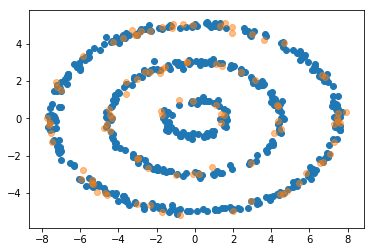

In [153]:
#np.random.seed(seed)

#rand_val_data1 = np.array([[xv,yv] for xv in np.linspace(-6,2,10) for yv in np.linspace(-7,-2,10)])
#rand_val_data2 = np.array([[xv,yv] for xv in np.linspace(2,7,10) for yv in np.linspace(-2,6,10)])
#rand_train_data = np.r_[rand_val_data1, rand_val_data2]
rand_train_data = gen_data(ntrain)
rand_points = gen_data(100)
rand_data_test  = gen_data(nval)

ndim_in = (rand_train_data.shape[1],)


np.random.shuffle(rand_train_data)
plt.scatter(rand_train_data[:,0],rand_train_data[:,1])
plt.scatter(rand_points[:,0],rand_points[:,1], alpha=0.5);

In [154]:
ngrid = 100

np.random.seed(1)

if D == 2:
    eval_points = np.array([[xv,yv] 
            for xv in np.linspace(-plot_size/2,plot_size/2,ngrid) 
                            for yv in np.linspace(-plot_size/2,plot_size/2,ngrid)])
    
print '=====building network'
if net_type=="s":
    network = LinearSoftNetwork(ndim_in, ndim, init_std=init_std)
elif net_type=="i":
    network = None

print '=====building kernel'

kernel  = GaussianKernel(sigma)

print '=====building network'

print '=====building model'
if net_type != "i":
    kn = KernelNetModel(kernel, network)
else:
    kn = KernelModel(kernel)
    
points  = tf.placeholder("float32", shape=(npoint, D), name="points")

kn.set_points(points)

loss, score, train_data, val_data, r_norm, l_norm, curve, alpha_assign = \
    kn.val_score(lam=lam, lam2=lam2, lam3=lam3)

test_data = tf.placeholder("float32", shape=(None, D), name="test_data")
fv = kn.evaluate_fun(test_data)
gv = kn.evaluate_grad(test_data)

=====building network
=====building kernel
=====building network
=====building model


In [155]:

#optimizer = tf.train.GradientDescentOptimizer(step_size)
#optimizer = tf.train.MomentumOptimizer(step_size, momentum=0.9)
optimizer = tf.train.AdamOptimizer(step_size)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1000)
train_step = optimizer.apply_gradients(zip(gradients, variables))

config = tf.ConfigProto(device_count={"GPU":1})
config.gpu_options.allow_growth=True



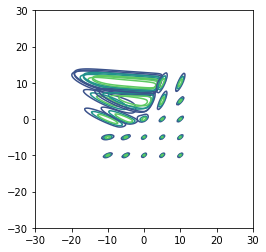

In [156]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

points_grid = np.array([[i,j] for i in np.linspace(-10,10,5) for j in np.linspace(-10,10,5)])

visualize_kernel(kn, np.linspace(-30,30,200), 3, points = points_grid);

In [157]:
scores = np.zeros(niter+1)
sigmas = np.zeros(niter+1)
lams   = np.zeros(niter+1)
lam2s  = np.zeros(niter+1)
lam3s  = np.zeros(niter+1)

fvs = []
W = []
rand_val_data = gen_data(nval)
rand_test_data = gen_data(nval)

feed   = {train_data: rand_train_data,
          val_data  : rand_val_data,
          test_data : rand_test_data}
test_grad_true = p.grad_multiple(rand_test_data)

t0 = time()

for i in range(niter+1):

    feed[val_data] = gen_data(nval)
    feed[train_data] = gen_data(ntrain)
    feed[points] = feed[train_data]


    if i % (niter/5) == 0 and D == 2:

        fv_val = sess.run(fv, feed_dict={train_data:feed[train_data], 
                                         test_data:eval_points,
                                         points: feed[train_data]})
        fv_val -= fv_val.mean()
        fv_val = np.exp(fv_val)
        fv_val /= np.sum(fv_val)
        fvs.append(fv_val) 


    train_step.run(feed_dict=feed)
    scores[i], r_norm_val, l_norm_val, curve_val, alpha_val = sess.run([score, r_norm, l_norm, 
                                                                        curve, kn.alpha], 
        feed_dict=feed)

    sigmas[i], lams[i], lam2s[i] ,lam3s[i]  = sess.run([sigma, lam, lam2, lam3])

    if i % min(100, niter/5) == 0:
        gv_val = gv.eval(feed)
        print '=================='
        
        print 'Iteration %5d, score %5.3g (%5.3g), time taken %.2f' % (i, scores[i], -D/4.0, time()-t0)
        print 'true score', 0.5*np.mean(np.sum((test_grad_true - gv_val)**2,1))
        print 'sigma: %.5f' % sigma.eval()
        print 'lam, lam2, lam3', lam.eval(), lam2.eval(), lam3.eval()
        print 'alpha: %.5g' % alpha_val.mean()
        print 'rn, ln, c = ', r_norm_val, l_norm_val, curve_val
        if net_type=="s":
            print kn.network.param["W"].eval().std()


Iteration     0, score  -1.5 ( -0.5), time taken 2.49
true score 7545.48755555
sigma: 0.93325
lam, lam2, lam3 0.0933254 0.0933254 0.0933254
alpha: 0.037303
rn, ln, c =  9.98693 2.68143 9.44222
1.11812
Iteration   100, score -25.8 ( -0.5), time taken 28.21
true score 7407.42114463
sigma: 1.99467
lam, lam2, lam3 0.000215004 0.000454183 0.00213078
alpha: 2.2716
rn, ln, c =  33429.4 6751.39 2935.12
0.978993
Iteration   200, score -31.6 ( -0.5), time taken 52.15
true score 7399.89893965
sigma: 3.02282
lam, lam2, lam3 6.70463e-05 0.000186524 0.00276621
alpha: 3.4987
rn, ln, c =  96900.0 19088.5 3267.01
0.95504
Iteration   300, score -33.5 ( -0.5), time taken 75.96
true score 7464.66231995
sigma: 3.14498
lam, lam2, lam3 3.07255e-05 0.00013763 0.00325116
alpha: 3.6544
rn, ln, c =  105439.0 26204.1 3035.29
0.966774
Iteration   400, score -27.1 ( -0.5), time taken 99.88
true score 7529.41361507
sigma: 3.35451
lam, lam2, lam3 2.12848e-05 0.000136962 0.00416078
alpha: 3.5852
rn, ln, c =  103713.0 

cv model score:  -31.011
cv true score:   7487.31294346
gs model score:  -27.9868164952
gs true score:   7469.38417989


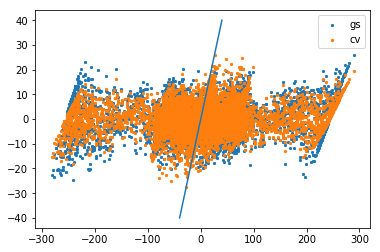

In [166]:
#np.random.seed(3)
batch_size = 500
rand_train_data = gen_data(batch_size)
rand_test_data = gen_data(batch_size*10)

ge_kn = []
sc = []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_train_data, 
                                              test_data: d, 
                                              points:rand_train_data,
                                              val_data: d})
    ge_kn += [o1]
    sc += [o2]

ge_kn = np.concatenate(ge_kn,0)
gt = p.grad_multiple(rand_test_data)
print "cv model score: ", np.mean(sc)
print "cv true score:  ", 0.5*np.mean(np.sum((ge_kn-gt)**2,1))


est = KMCLite(m = 500, sigma = np.exp(0.1224), lmbda = np.exp(-4.1224))

est.fit(rand_train_data)

ge = est.grad(rand_test_data)

sc = []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    sc += [est.score(d)]
print "gs model score: ", np.mean(sc)
print "gs true score:  ", 0.5*np.mean(np.sum((ge-gt)**2,1))
plt.scatter(gt.flatten(), ge.flatten(), 5, marker='x');
plt.scatter(gt.flatten(), ge_kn.flatten(), 5, marker='o');
plt.legend(["gs","cv"])
plt.plot([-40,40],[-40,40])

WilcoxonResult(statistic=5951760.0, pvalue=0.0033467742370825531)
MannwhitneyuResult(statistic=12452470.0, pvalue=0.37097294737192155)


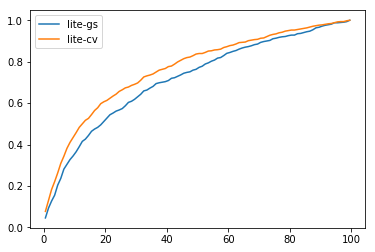

In [167]:
from scipy.stats import mannwhitneyu, ttest_rel, wilcoxon

def plot_error_cdf(data, bins = 10, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    counts, _ = np.histogram(data, bins=bins, normed=True)
    centers = 0.5*(bins[1:]+bins[:-1])
    cdf    = np.cumsum(counts)
    ax.plot(centers, cdf)
    
fig, ax = plt.subplots()
bins = np.linspace(0,100,101)

lite_errors = np.sum((ge-gt)**2,1)
kn_errors = np.sum((ge_kn-gt)**2,1)

plot_error_cdf(lite_errors, bins = bins, ax=ax)
plot_error_cdf(kn_errors, bins = bins, ax=ax)
plt.legend(["lite-gs","lite-cv"])
print wilcoxon(lite_errors, kn_errors)
print mannwhitneyu(lite_errors, kn_errors)

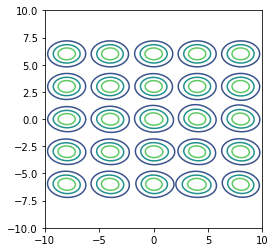

In [173]:
points_grid = np.array([[i,j] for i in np.linspace(-8,8,5) for j in np.linspace(-6,6,5)])

K = visualize_kernel(kn, np.linspace(-10,10,200), 3, points=points_grid)
plt.gca().set_aspect("equal")

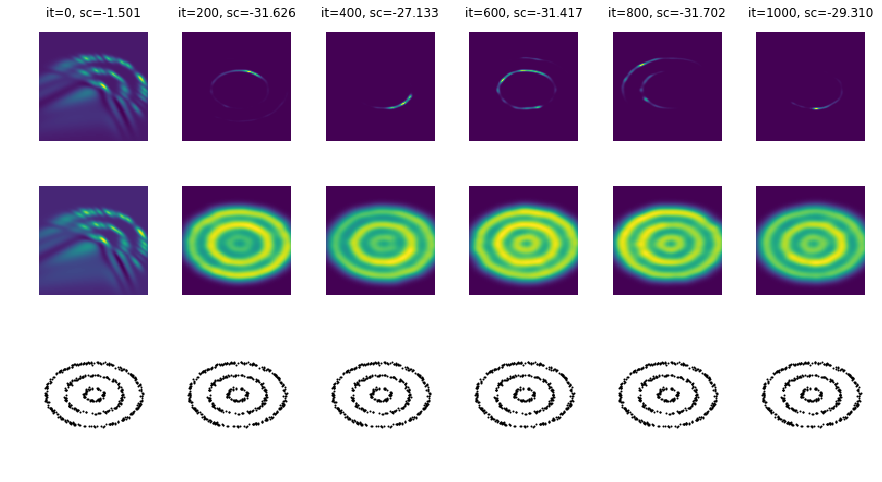

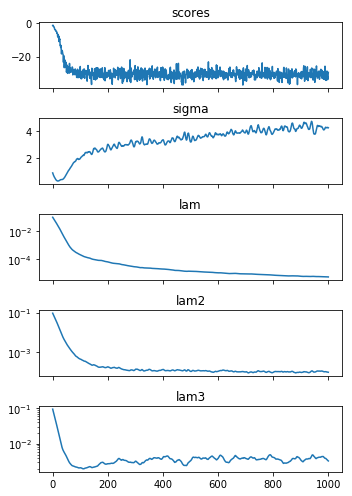

In [165]:

nfvs  = len(fvs)
fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
rand_data = (ngrid/2)+(rand_train_data*ngrid/plot_size)
vmin = min(map(np.min, fvs))
vmax = max(map(np.max, fvs))

for i in range(len(fvs)):

    iter_number = niter/5*i
    ax = axes[0, i]

    hist = (fvs[i])

    ax.imshow( hist.reshape(ngrid, ngrid).T)
    ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
    ax.set_axis_off()

    ax = axes[1, i]
    ax.imshow( np.log(hist).reshape(ngrid, ngrid).T)
    ax.set_axis_off()


    ax = axes[2, i]
    ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1)
    ax.set_axis_off()


#plt.show()
#fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
#fig.savefig("figs/grid_dist/test.pdf") 

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lams)
ax.set_title("lam")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam2s)
ax.set_title("lam2")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam3s)
ax.set_title("lam3")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 